# Modelo Support Vector Regression (SVR) para Predicción de Potencia

Este notebook implementa el modelo **Support Vector Regression (SVR)** - Máquina de Vectores de Soporte.

**Características:**
- Feature engineering con ordenamiento canónico
- Optimización de hiperparámetros (C, epsilon, kernel, gamma)
- Entrenamiento paralelo para todos los datasets
- Evaluación completa con métricas (RMSE, MAE, R, MAPE)
- Visualizaciones y análisis de resultados

## 1. Importaciones y Configuración


In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pickle
import time
import random
from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

# Optimización Bayesiana con Optuna (opcional)
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Optuna no está instalado. Se usará RandomizedSearchCV")
    OPTUNA_AVAILABLE = False

warnings.filterwarnings('ignore')

# Configuración
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Directorios
DATASET_DIR = Path("dataset")
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

GLOBAL_SEED = 42
GLOBALS_DATASET_SEEDS = {
    "perth_49": GLOBAL_SEED + 1,
    "sydney_49": GLOBAL_SEED + 2,
    "perth_100": GLOBAL_SEED + 3,
    "sydney_100": GLOBAL_SEED + 4,
}

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

print("Librerías importadas correctamente")


Librerías importadas correctamente


C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_global_seeds(seed: int = GLOBAL_SEED) -> None:
    """Fija las semillas globales para garantizar reproducibilidad."""
    random.seed(seed)
    np.random.seed(seed)


def sample_with_seed(X, y, max_samples=5000, seed=GLOBAL_SEED):
    """Devuelve una muestra reproducible (sin reemplazo) si el dataset supera max_samples."""
    if len(X) > max_samples:
        rng = np.random.RandomState(seed)
        sample_idx = rng.choice(len(X), max_samples, replace=False)
        return X[sample_idx], y[sample_idx], True
    return X, y, False


def describe_target_distribution(values, label):
    """Imprime estadísticas básicas de la variable objetivo para monitorear el split."""
    print(
        f"{label} -> media: {np.mean(values):.2f}, std: {np.std(values):.2f}, min: {np.min(values):.2f}, max: {np.max(values):.2f}"
    )


set_global_seeds(GLOBAL_SEED)


## 2. Clase FeatureEngineer


In [3]:
class FeatureEngineer:
    """Clase para ingeniería de características con ordenamiento canónico."""
    
    def __init__(self, n_converters):
        self.n_converters = n_converters
    
    def canonical_ordering(self, coordinates):
        n_samples = coordinates.shape[0]
        coordinates_ordered = np.zeros_like(coordinates)
        for i in range(n_samples):
            coords = coordinates[i].copy()
            sort_indices = np.lexsort((coords[:, 1], coords[:, 0]))
            coordinates_ordered[i] = coords[sort_indices]
        return coordinates_ordered
    
    def extract_coordinates(self, df):
        x_cols = [f'X{i+1}' for i in range(self.n_converters)]
        y_cols = [f'Y{i+1}' for i in range(self.n_converters)]
        x_values = df[x_cols].values
        y_values = df[y_cols].values
        coordinates = np.stack([x_values, y_values], axis=2)
        return coordinates
    
    def compute_centroid(self, coordinates):
        return coordinates.mean(axis=1)
    
    def compute_distances_to_centroid(self, coordinates, centroids):
        n_samples = coordinates.shape[0]
        distances = np.zeros((n_samples, self.n_converters))
        for i in range(n_samples):
            centroid = centroids[i]
            coords = coordinates[i]
            distances[i] = np.sqrt(np.sum((coords - centroid)**2, axis=1))
        return distances
    
    def compute_neighbor_distances(self, coordinates, k=3):
        n_samples = coordinates.shape[0]
        min_distances = np.zeros((n_samples, self.n_converters))
        mean_distances = np.zeros((n_samples, self.n_converters))
        for i in range(n_samples):
            coords = coordinates[i]
            for j in range(self.n_converters):
                distances = np.sqrt(np.sum((coords - coords[j])**2, axis=1))
                distances[j] = np.inf
                k_nearest = np.partition(distances, min(k, len(distances)-1))[:k+1]
                k_nearest = k_nearest[k_nearest != np.inf]
                if len(k_nearest) > 0:
                    min_distances[i, j] = np.min(k_nearest)
                    mean_distances[i, j] = np.mean(k_nearest[:k])
        return min_distances, mean_distances
    
    def compute_spatial_metrics(self, coordinates):
        n_samples = coordinates.shape[0]
        metrics = {
            'max_distance': np.zeros(n_samples),
            'min_distance': np.zeros(n_samples),
            'mean_distance': np.zeros(n_samples),
            'std_distance': np.zeros(n_samples)
        }
        for i in range(n_samples):
            coords = coordinates[i]
            distances = []
            for j in range(self.n_converters):
                for k in range(j+1, self.n_converters):
                    dist = np.linalg.norm(coords[j] - coords[k])
                    distances.append(dist)
            if distances:
                distances = np.array(distances)
                metrics['max_distance'][i] = np.max(distances)
                metrics['min_distance'][i] = np.min(distances)
                metrics['mean_distance'][i] = np.mean(distances)
                metrics['std_distance'][i] = np.std(distances)
        return metrics
    
    def compute_shadowing_index(self, coordinates, wave_direction='left', y_bandwidth=50.0):
        n_samples = coordinates.shape[0]
        shadowing_index = np.zeros((n_samples, self.n_converters))
        for i in range(n_samples):
            coords = coordinates[i]
            for j in range(self.n_converters):
                current_x = coords[j, 0]
                current_y = coords[j, 1]
                upstream_count = 0
                for k in range(self.n_converters):
                    if k == j:
                        continue
                    other_x = coords[k, 0]
                    other_y = coords[k, 1]
                    y_distance = abs(other_y - current_y)
                    if y_distance > y_bandwidth:
                        continue
                    if wave_direction == 'left':
                        if other_x < current_x:
                            upstream_count += 1
                    elif wave_direction == 'right':
                        if other_x > current_x:
                            upstream_count += 1
                shadowing_index[i, j] = upstream_count
        return shadowing_index
    
    def transform(self, df):
        coordinates = self.extract_coordinates(df)
        coordinates = self.canonical_ordering(coordinates)
        n_samples = coordinates.shape[0]
        X_coords = coordinates.reshape(n_samples, -1)
        coord_feature_names = []
        for i in range(self.n_converters):
            coord_feature_names.append(f'X{i+1}_ordered')
            coord_feature_names.append(f'Y{i+1}_ordered')
        X_list = [X_coords]
        feature_names_list = [coord_feature_names]
        centroids = self.compute_centroid(coordinates)
        dist_to_centroid = self.compute_distances_to_centroid(coordinates, centroids)
        min_dist, mean_dist = self.compute_neighbor_distances(coordinates, k=3)
        spatial_metrics = self.compute_spatial_metrics(coordinates)
        shadowing_index = self.compute_shadowing_index(coordinates, wave_direction='left', y_bandwidth=50.0)
        X_list.extend([
            dist_to_centroid,
            min_dist,
            mean_dist,
            np.column_stack([
                spatial_metrics['max_distance'],
                spatial_metrics['min_distance'],
                spatial_metrics['mean_distance'],
                spatial_metrics['std_distance']
            ]),
            shadowing_index
        ])
        feature_names_list.extend([
            [f'dist_centroid_{i+1}' for i in range(self.n_converters)],
            [f'min_dist_neighbor_{i+1}' for i in range(self.n_converters)],
            [f'mean_dist_neighbor_{i+1}' for i in range(self.n_converters)],
            ['max_distance', 'min_distance', 'mean_distance', 'std_distance'],
            [f'shadowing_index_{i+1}' for i in range(self.n_converters)]
        ])
        X = np.hstack(X_list)
        feature_names = [name for sublist in feature_names_list for name in sublist]
        y = df['Total_Power'].values
        return X, y, feature_names

print("Clase FeatureEngineer definida")


Clase FeatureEngineer definida


## 3. Funciones de Utilidad


In [4]:
def calculate_metrics(y_true, y_pred):
    """Calcula todas las métricas de evaluación, manejando divisiones por cero en MAPE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    safe_denominator = np.where(y_true == 0, np.finfo(float).eps, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / safe_denominator)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

print("Funciones de utilidad definidas")


Funciones de utilidad definidas


## 4. Función de Optimización de Hiperparámetros


In [5]:
def optimize_svr(X_train, y_train, X_val, y_val, use_optuna=True, random_seed=GLOBAL_SEED, dataset_label="default"):
    """Optimiza hiperparámetros de SVR con muestreo reproducible."""
    X_train_sampled, y_train_sampled, _ = sample_with_seed(
        X_train, y_train, max_samples=5000, seed=random_seed
    )

    if use_optuna and OPTUNA_AVAILABLE:
        def objective(trial):
            C = trial.suggest_float('C', 0.1, 1000.0, log=True)
            epsilon = trial.suggest_float('epsilon', 1e-3, 10.0, log=True)
            kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
            gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True)
            params = {'C': C, 'epsilon': epsilon, 'kernel': kernel, 'gamma': gamma}
            if kernel == 'poly':
                params['degree'] = trial.suggest_int('degree', 2, 4)
            model = SVR(**params)
            try:
                model.fit(X_train_sampled, y_train_sampled)
                y_pred = model.predict(X_val)
                return mean_squared_error(y_val, y_pred)
            except Exception as exc:  # noqa: BLE001
                print(f"Trial descartado por error: {exc}")
                return float('inf')

        sampler = optuna.samplers.TPESampler(seed=random_seed) if OPTUNA_AVAILABLE else None
        pruner = optuna.pruners.MedianPruner() if OPTUNA_AVAILABLE else None
        study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
        study.optimize(objective, n_trials=30, show_progress_bar=True)

        best_params = study.best_params

        print(f"Mejores parámetros SVR ({dataset_label}): {best_params}")
        print(f"Mejor MSE: {study.best_value:.2f}")

        # Entrenar con todos los datos
        model = SVR(**best_params)
        model.fit(X_train, y_train)

        return model, best_params
    else:
        # RandomizedSearchCV como fallback
        param_distributions = {
            'C': [0.1, 1, 10, 100, 1000],
            'epsilon': [0.01, 0.1, 1, 10],
            'kernel': ['rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        }

        print("Optimizando SVR con RandomizedSearchCV...")
        X_train_sample, y_train_sample, _ = sample_with_seed(
            X_train, y_train, max_samples=5000, seed=random_seed
        )
        random_search = RandomizedSearchCV(
            SVR(),
            param_distributions,
            n_iter=15,
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1,
            random_state=random_seed
        )
        random_search.fit(X_train_sample, y_train_sample)

        # Entrenar modelo final con todos los datos
        final_model = SVR(**random_search.best_params_)
        final_model.fit(X_train, y_train)

        print(f"Mejores parámetros SVR ({dataset_label}): {random_search.best_params_}")
        print(f"Mejor MSE: {-random_search.best_score_:.2f}")

        return final_model, random_search.best_params_

print("Función de optimización SVR definida")


Función de optimización SVR definida


## 5. Función Principal de Entrenamiento


In [6]:
def train_svr_for_dataset_legacy(dataset_name):
    """
    Entrena un modelo SVR para un dataset específico.
    
    Args:
        dataset_name: nombre del dataset ('perth_49', 'sydney_49', 'perth_100', 'sydney_100')
    
    Returns:
        dict: resultados del entrenamiento
    """
    # Importar módulos necesarios (para ejecución paralela)
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from sklearn.model_selection import train_test_split, RandomizedSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.svm import SVR
    import pickle
    import time
    
    # Verificar disponibilidad de Optuna
    try:
        import optuna
        OPTUNA_AVAILABLE_LOCAL = True
    except ImportError:
        OPTUNA_AVAILABLE_LOCAL = False
    
    # Definir FeatureEngineer dentro de la función (para serialización en paralelo)
    class FeatureEngineer:
        """Clase para ingeniería de características con ordenamiento canónico."""
        def __init__(self, n_converters):
            self.n_converters = n_converters
        def canonical_ordering(self, coordinates):
            n_samples = coordinates.shape[0]
            coordinates_ordered = np.zeros_like(coordinates)
            for i in range(n_samples):
                coords = coordinates[i].copy()
                sort_indices = np.lexsort((coords[:, 1], coords[:, 0]))
                coordinates_ordered[i] = coords[sort_indices]
            return coordinates_ordered
        def extract_coordinates(self, df):
            x_cols = [f'X{i+1}' for i in range(self.n_converters)]
            y_cols = [f'Y{i+1}' for i in range(self.n_converters)]
            x_values = df[x_cols].values
            y_values = df[y_cols].values
            coordinates = np.stack([x_values, y_values], axis=2)
            return coordinates
        def compute_centroid(self, coordinates):
            return coordinates.mean(axis=1)
        def compute_distances_to_centroid(self, coordinates, centroids):
            n_samples = coordinates.shape[0]
            distances = np.zeros((n_samples, self.n_converters))
            for i in range(n_samples):
                centroid = centroids[i]
                coords = coordinates[i]
                distances[i] = np.sqrt(np.sum((coords - centroid)**2, axis=1))
            return distances
        def compute_neighbor_distances(self, coordinates, k=3):
            n_samples = coordinates.shape[0]
            min_distances = np.zeros((n_samples, self.n_converters))
            mean_distances = np.zeros((n_samples, self.n_converters))
            for i in range(n_samples):
                coords = coordinates[i]
                for j in range(self.n_converters):
                    distances = np.sqrt(np.sum((coords - coords[j])**2, axis=1))
                    distances[j] = np.inf
                    k_nearest = np.partition(distances, min(k, len(distances)-1))[:k+1]
                    k_nearest = k_nearest[k_nearest != np.inf]
                    if len(k_nearest) > 0:
                        min_distances[i, j] = np.min(k_nearest)
                        mean_distances[i, j] = np.mean(k_nearest[:k])
            return min_distances, mean_distances
        def compute_spatial_metrics(self, coordinates):
            n_samples = coordinates.shape[0]
            metrics = {'max_distance': np.zeros(n_samples), 'min_distance': np.zeros(n_samples),
                      'mean_distance': np.zeros(n_samples), 'std_distance': np.zeros(n_samples)}
            for i in range(n_samples):
                coords = coordinates[i]
                distances = []
                for j in range(self.n_converters):
                    for k in range(j+1, self.n_converters):
                        dist = np.linalg.norm(coords[j] - coords[k])
                        distances.append(dist)
                if distances:
                    distances = np.array(distances)
                    metrics['max_distance'][i] = np.max(distances)
                    metrics['min_distance'][i] = np.min(distances)
                    metrics['mean_distance'][i] = np.mean(distances)
                    metrics['std_distance'][i] = np.std(distances)
            return metrics
        def compute_shadowing_index(self, coordinates, wave_direction='left', y_bandwidth=50.0):
            n_samples = coordinates.shape[0]
            shadowing_index = np.zeros((n_samples, self.n_converters))
            for i in range(n_samples):
                coords = coordinates[i]
                for j in range(self.n_converters):
                    current_x, current_y = coords[j, 0], coords[j, 1]
                    upstream_count = 0
                    for k in range(self.n_converters):
                        if k == j: continue
                        other_x, other_y = coords[k, 0], coords[k, 1]
                        if abs(other_y - current_y) > y_bandwidth: continue
                        if wave_direction == 'left' and other_x < current_x: upstream_count += 1
                        elif wave_direction == 'right' and other_x > current_x: upstream_count += 1
                    shadowing_index[i, j] = upstream_count
            return shadowing_index
        def transform(self, df):
            coordinates = self.extract_coordinates(df)
            coordinates = self.canonical_ordering(coordinates)
            n_samples = coordinates.shape[0]
            X_coords = coordinates.reshape(n_samples, -1)
            coord_feature_names = []
            for i in range(self.n_converters):
                coord_feature_names.append(f'X{i+1}_ordered')
                coord_feature_names.append(f'Y{i+1}_ordered')
            X_list = [X_coords]
            feature_names_list = [coord_feature_names]
            centroids = self.compute_centroid(coordinates)
            dist_to_centroid = self.compute_distances_to_centroid(coordinates, centroids)
            min_dist, mean_dist = self.compute_neighbor_distances(coordinates, k=3)
            spatial_metrics = self.compute_spatial_metrics(coordinates)
            shadowing_index = self.compute_shadowing_index(coordinates, wave_direction='left', y_bandwidth=50.0)
            X_list.extend([dist_to_centroid, min_dist, mean_dist,
                          np.column_stack([spatial_metrics['max_distance'], spatial_metrics['min_distance'],
                                          spatial_metrics['mean_distance'], spatial_metrics['std_distance']]),
                          shadowing_index])
            feature_names_list.extend([[f'dist_centroid_{i+1}' for i in range(self.n_converters)],
                                      [f'min_dist_neighbor_{i+1}' for i in range(self.n_converters)],
                                      [f'mean_dist_neighbor_{i+1}' for i in range(self.n_converters)],
                                      ['max_distance', 'min_distance', 'mean_distance', 'std_distance'],
                                      [f'shadowing_index_{i+1}' for i in range(self.n_converters)]])
            X = np.hstack(X_list)
            feature_names = [name for sublist in feature_names_list for name in sublist]
            y = df['Total_Power'].values
            return X, y, feature_names
    
    def calculate_metrics_local(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    
    def optimize_svr_local(X_train, y_train, X_val, y_val):
        if OPTUNA_AVAILABLE_LOCAL:
            def objective(trial):
                C = trial.suggest_float('C', 0.1, 1000.0, log=True)
                epsilon = trial.suggest_float('epsilon', 1e-3, 10.0, log=True)
                kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
                gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True)
                params = {'C': C, 'epsilon': epsilon, 'kernel': kernel, 'gamma': gamma}
                if kernel == 'poly':
                    params['degree'] = trial.suggest_int('degree', 2, 4)
                model = SVR(**params)
                try:
                    if len(X_train) > 5000:
                        sample_idx = np.random.choice(len(X_train), 5000, replace=False)
                        model.fit(X_train[sample_idx], y_train[sample_idx])
                    else:
                        model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)
                    return mean_squared_error(y_val, y_pred)
                except:
                    return float('inf')
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=30, show_progress_bar=False)
            best_params = study.best_params
            model = SVR(**best_params)
            model.fit(X_train, y_train)
            return model, best_params
        else:
            param_distributions = {'C': [0.1, 1, 10, 100, 1000], 'epsilon': [0.01, 0.1, 1, 10], 'kernel': ['rbf', 'poly'],
                                 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}
            if len(X_train) > 5000:
                sample_idx = np.random.choice(len(X_train), 5000, replace=False)
                X_train_sample, y_train_sample = X_train[sample_idx], y_train[sample_idx]
            else:
                X_train_sample, y_train_sample = X_train, y_train
            random_search = RandomizedSearchCV(SVR(), param_distributions, n_iter=15, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0, random_state=42)
            random_search.fit(X_train_sample, y_train_sample)
            final_model = SVR(**random_search.best_params_)
            final_model.fit(X_train, y_train)
            return final_model, random_search.best_params_
    
    print(f"\n{'='*70}")
    print(f"Procesando: {dataset_name} - Modelo: SVR")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    try:
        DATASET_DIR = Path("dataset")
        MODELS_DIR = Path("models")
        MODELS_DIR.mkdir(exist_ok=True)
        
        dataset_files = {"perth_49": "WEC_Perth_49.csv", "perth_100": "WEC_Perth_100.csv",
                        "sydney_49": "WEC_Sydney_49.csv", "sydney_100": "WEC_Sydney_100.csv"}
        
        DATASET_FILE = DATASET_DIR / dataset_files[dataset_name]
        N_CONVERTERS = 49 if "49" in dataset_name else 100
        
        print(f"Dataset: {dataset_name}")
        print(f"Archivo: {DATASET_FILE}")
        print(f"Convertidores: {N_CONVERTERS}")
        
        df = pd.read_csv(DATASET_FILE)
        df_original = len(df)
        df = df.drop_duplicates()
        print(f"Datos cargados: {df_original:,} filas × {len(df.columns)} columnas")
        print(f"Duplicados eliminados: {df_original - len(df):,} filas")
        print(f"Filas únicas: {len(df):,}")
        
        fe = FeatureEngineer(N_CONVERTERS)
        X, y, feature_names = fe.transform(df)
        print(f"Features generadas: {len(feature_names)}")
        
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"\nOptimizando hiperparámetros para SVR...")
        best_model, best_params = optimize_svr_local(X_train_scaled, y_train, X_val_scaled, y_val)
        
        y_pred_train = best_model.predict(X_train_scaled)
        y_pred_val = best_model.predict(X_val_scaled)
        y_pred_test = best_model.predict(X_test_scaled)
        
        metrics_train = calculate_metrics_local(y_train, y_pred_train)
        metrics_val = calculate_metrics_local(y_val, y_pred_val)
        metrics_test = calculate_metrics_local(y_test, y_pred_test)
        
        print(f"\n{'='*70}")
        print(f"RESULTADOS - {dataset_name.upper()} - SVR")
        print(f"{'='*70}")
        print(f"Train Set: RMSE={metrics_train['RMSE']:.2f}W, R²={metrics_train['R2']:.4f}, MAPE={metrics_train['MAPE']:.2f}%")
        print(f"Validation Set: RMSE={metrics_val['RMSE']:.2f}W, R²={metrics_val['R2']:.4f}, MAPE={metrics_val['MAPE']:.2f}%")
        print(f"Test Set: RMSE={metrics_test['RMSE']:.2f}W, R²={metrics_test['R2']:.4f}, MAPE={metrics_test['MAPE']:.2f}%")
        
        overfitting_gap = metrics_train['RMSE'] / metrics_test['RMSE'] if metrics_test['RMSE'] > 0 else 0
        print(f"Gap Train/Test RMSE: {overfitting_gap:.2f}x")
        
        model_data = {'model': best_model, 'scaler': scaler, 'feature_names': feature_names,
                     'n_converters': N_CONVERTERS, 'dataset_name': dataset_name, 'model_type': 'svr',
                     'best_params': best_params, 'metrics': {'train': metrics_train, 'val': metrics_val, 'test': metrics_test},
                     'overfitting_gap': overfitting_gap}
        
        model_file = MODELS_DIR / f"modelo_svr_{dataset_name}.pkl"
        with open(model_file, 'wb') as f:
            pickle.dump(model_data, f)
        
        elapsed_time = time.time() - start_time
        print(f"Modelo guardado en: {model_file}")
        print(f"Tiempo de entrenamiento: {elapsed_time/60:.2f} minutos")
        
        return {'dataset': dataset_name, 'model_type': 'svr', 'metrics': {'train': metrics_train, 'val': metrics_val, 'test': metrics_test},
               'overfitting_gap': overfitting_gap, 'time': elapsed_time, 'best_params': best_params}
        
    except Exception as e:
        print(f"\nERROR procesando {dataset_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return {'dataset': dataset_name, 'model_type': 'svr', 'error': str(e)}

print("Función de entrenamiento SVR definida")


Función de entrenamiento SVR definida


In [7]:
def train_svr_for_dataset(dataset_name):
    """Entrena y evalúa un SVR con configuraciones reproducibles."""
    print(f"\n{'='*70}")
    print(f"Procesando: {dataset_name} - Modelo: SVR")
    print(f"{'='*70}")

    dataset_seed = GLOBALS_DATASET_SEEDS.get(dataset_name, GLOBAL_SEED)
    start_time = time.time()

    try:
        dataset_files = {
            "perth_49": "WEC_Perth_49.csv",
            "perth_100": "WEC_Perth_100.csv",
            "sydney_49": "WEC_Sydney_49.csv",
            "sydney_100": "WEC_Sydney_100.csv",
        }

        DATASET_FILE = DATASET_DIR / dataset_files[dataset_name]
        N_CONVERTERS = 49 if "49" in dataset_name else 100

        df = pd.read_csv(DATASET_FILE)
        df_original = len(df)
        df = df.drop_duplicates()
        print(f"Datos cargados: {df_original:,} filas × {len(df.columns)} columnas")
        print(f"Duplicados eliminados: {df_original - len(df):,} filas")
        print(f"Filas únicas: {len(df):,}")

        fe = FeatureEngineer(N_CONVERTERS)
        X, y, feature_names = fe.transform(df)
        print(f"Features generadas: {len(feature_names)}")

        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=GLOBAL_SEED, shuffle=True
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, random_state=GLOBAL_SEED, shuffle=True
        )

        describe_target_distribution(y_train, "Train target")
        describe_target_distribution(y_val, "Val target")
        describe_target_distribution(y_test, "Test target")

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        print("\nOptimizando hiperparámetros para SVR...")
        best_model, best_params = optimize_svr(
            X_train_scaled,
            y_train,
            X_val_scaled,
            y_val,
            use_optuna=OPTUNA_AVAILABLE,
            random_seed=dataset_seed,
            dataset_label=dataset_name,
        )

        y_pred_train = best_model.predict(X_train_scaled)
        y_pred_val = best_model.predict(X_val_scaled)
        y_pred_test = best_model.predict(X_test_scaled)

        metrics_train = calculate_metrics(y_train, y_pred_train)
        metrics_val = calculate_metrics(y_val, y_pred_val)
        metrics_test = calculate_metrics(y_test, y_pred_test)

        print(f"\n{'='*70}")
        print(f"RESULTADOS - {dataset_name.upper()} - SVR")
        print(f"{'='*70}")
        print(
            f"Train Set: RMSE={metrics_train['RMSE']:.2f}W, R²={metrics_train['R2']:.4f}, MAPE={metrics_train['MAPE']:.2f}%"
        )
        print(
            f"Validation Set: RMSE={metrics_val['RMSE']:.2f}W, R²={metrics_val['R2']:.4f}, MAPE={metrics_val['MAPE']:.2f}%"
        )
        print(
            f"Test Set: RMSE={metrics_test['RMSE']:.2f}W, R²={metrics_test['R2']:.4f}, MAPE={metrics_test['MAPE']:.2f}%"
        )

        overfitting_gap = (
            metrics_test['RMSE'] / metrics_train['RMSE'] if metrics_train['RMSE'] > 0 else np.inf
        )
        print(f"Relación RMSE Test/Train: {overfitting_gap:.2f}x")

        model_data = {
            'model': best_model,
            'scaler': scaler,
            'feature_names': feature_names,
            'n_converters': N_CONVERTERS,
            'dataset_name': dataset_name,
            'model_type': 'svr',
            'best_params': best_params,
            'metrics': {'train': metrics_train, 'val': metrics_val, 'test': metrics_test},
            'overfitting_gap': overfitting_gap,
            'random_seed': dataset_seed,
        }

        model_file = MODELS_DIR / f"modelo_svr_{dataset_name}.pkl"
        with open(model_file, 'wb') as f:
            pickle.dump(model_data, f)

        elapsed_time = time.time() - start_time
        print(f"Modelo guardado en: {model_file}")
        print(f"Tiempo de entrenamiento: {elapsed_time/60:.2f} minutos")

        return {
            'dataset': dataset_name,
            'model_type': 'svr',
            'metrics': {'train': metrics_train, 'val': metrics_val, 'test': metrics_test},
            'overfitting_gap': overfitting_gap,
            'time': elapsed_time,
            'best_params': best_params,
        }

    except Exception as exc:  # noqa: BLE001
        print(f"\nERROR procesando {dataset_name}: {exc}")
        import traceback
        traceback.print_exc()
        return {'dataset': dataset_name, 'model_type': 'svr', 'error': str(exc)}

print("Función de entrenamiento SVR definida (versión reproducible)")


Función de entrenamiento SVR definida (versión reproducible)


In [8]:
# Lista de datasets a procesar
datasets = ["perth_49", "sydney_49", "perth_100", "sydney_100"]

print(f"\n{'='*70}")
print(f"ENTRENAMIENTO PARALELO DE MODELOS SVR")
print(f"{'='*70}")
print(f"Datasets: {', '.join(datasets)}")
print(f"Total de modelos: {len(datasets)}")

start_total = time.time()

# Entrenar en paralelo (n_jobs=2 para evitar saturación de memoria)
results = Parallel(n_jobs=2, verbose=10)(
    delayed(train_svr_for_dataset)(dataset) for dataset in datasets
)

elapsed_total = time.time() - start_total

print(f"\n{'='*70}")
print(f"ENTRENAMIENTO COMPLETADO")
print(f"{'='*70}")
print(f"Tiempo total: {elapsed_total/60:.2f} minutos")

# Resumen de resultados
print(f"\n{'='*70}")
print(f"RESUMEN DE RESULTADOS")
print(f"{'='*70}")

for result in results:
    if 'error' not in result:
        dataset = result['dataset']
        metrics = result['metrics']['test']
        gap = result['overfitting_gap']
        print(f"\n{dataset.upper()}:")
        print(f"  R² (test): {metrics['R2']:.4f}")
        print(f"  RMSE (test): {metrics['RMSE']:.2f} W")
        print(f"  MAPE (test): {metrics['MAPE']:.2f}%")
        print(f"  RMSE Test/Train: {gap:.2f}x")
        print(f"  Tiempo: {result['time']/60:.2f} min")
    else:
        print(f"\n{result['dataset'].upper()}: ERROR - {result['error']}")



ENTRENAMIENTO PARALELO DE MODELOS SVR
Datasets: perth_49, sydney_49, perth_100, sydney_100
Total de modelos: 4


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:  6.0min remaining:  6.0min



ENTRENAMIENTO COMPLETADO
Tiempo total: 32.21 minutos

RESUMEN DE RESULTADOS

PERTH_49:
  R² (test): 0.8638
  RMSE (test): 46182.63 W
  MAPE (test): 0.74%
  RMSE Test/Train: 2.62x
  Tiempo: 32.14 min

SYDNEY_49:
  R² (test): 0.9498
  RMSE (test): 18295.94 W
  MAPE (test): 0.31%
  RMSE Test/Train: 236.20x
  Tiempo: 3.24 min

PERTH_100:
  R² (test): 0.7680
  RMSE (test): 97545.88 W
  MAPE (test): 1.01%
  RMSE Test/Train: 324922.02x
  Tiempo: 2.72 min

SYDNEY_100:
  R² (test): 0.7452
  RMSE (test): 62221.57 W
  MAPE (test): 0.57%
  RMSE Test/Train: 1220356.84x
  Tiempo: 0.74 min


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 32.2min finished


## 7. Visualización de Resultados


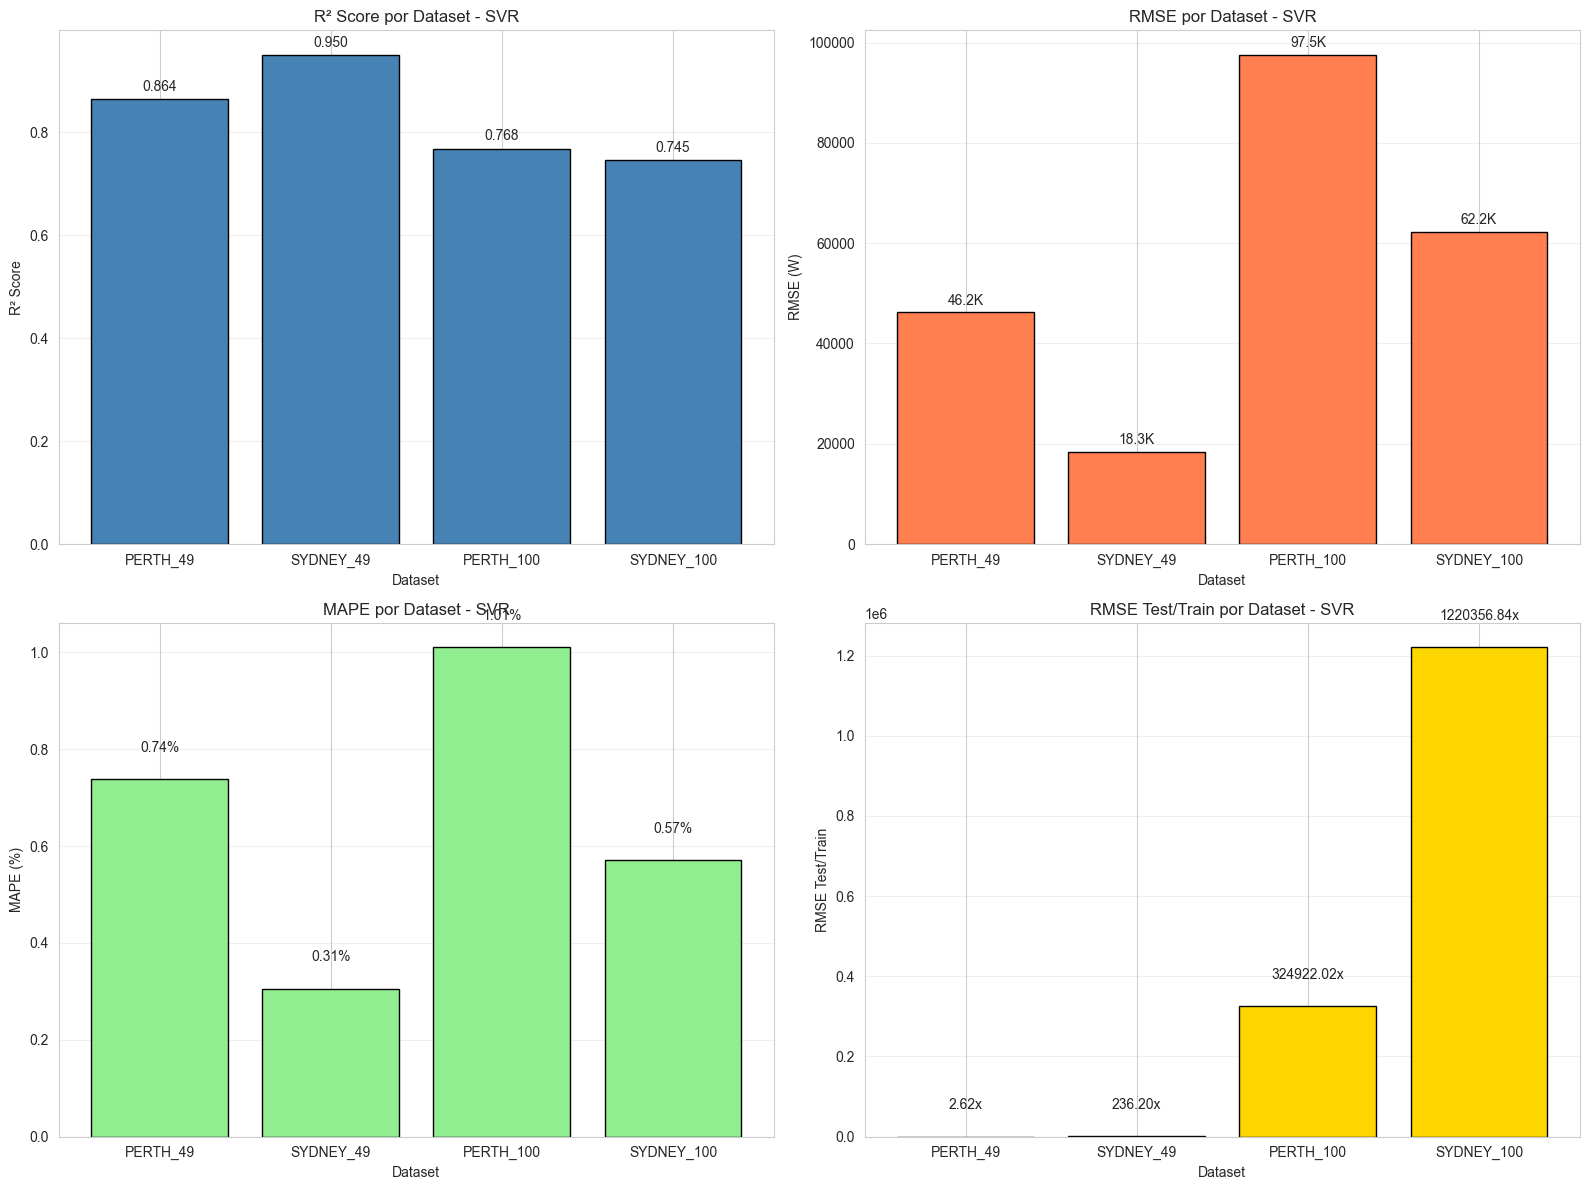


Visualización guardada como 'resultados_svr.png'


In [9]:
# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

datasets_ordered = ['perth_49', 'sydney_49', 'perth_100', 'sydney_100']

# Extraer métricas
r2_scores = []
rmse_scores = []
mape_scores = []
gaps = []

for d in datasets_ordered:
    result = next((r for r in results if r.get('dataset') == d and 'error' not in r), None)
    if result:
        r2_scores.append(result['metrics']['test']['R2'])
        rmse_scores.append(result['metrics']['test']['RMSE'])
        mape_scores.append(result['metrics']['test']['MAPE'])
        gaps.append(result['overfitting_gap'])
    else:
        r2_scores.append(0)
        rmse_scores.append(0)
        mape_scores.append(0)
        gaps.append(0)

# Gráfico 1: R² por dataset
ax = axes[0]
ax.bar(range(len(datasets_ordered)), r2_scores, color='steelblue', edgecolor='black')
ax.set_xlabel('Dataset')
ax.set_ylabel('R² Score')
ax.set_title('R² Score por Dataset - SVR')
ax.set_xticks(range(len(datasets_ordered)))
ax.set_xticklabels([d.upper() for d in datasets_ordered])
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_scores):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Gráfico 2: RMSE por dataset
ax = axes[1]
ax.bar(range(len(datasets_ordered)), rmse_scores, color='coral', edgecolor='black')
ax.set_xlabel('Dataset')
ax.set_ylabel('RMSE (W)')
ax.set_title('RMSE por Dataset - SVR')
ax.set_xticks(range(len(datasets_ordered)))
ax.set_xticklabels([d.upper() for d in datasets_ordered])
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_scores):
    ax.text(i, v + max(rmse_scores)*0.01, f'{v/1000:.1f}K', ha='center', va='bottom')

# Gráfico 3: MAPE por dataset
ax = axes[2]
ax.bar(range(len(datasets_ordered)), mape_scores, color='lightgreen', edgecolor='black')
ax.set_xlabel('Dataset')
ax.set_ylabel('MAPE (%)')
ax.set_title('MAPE por Dataset - SVR')
ax.set_xticks(range(len(datasets_ordered)))
ax.set_xticklabels([d.upper() for d in datasets_ordered])
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mape_scores):
    ax.text(i, v + max(mape_scores)*0.05, f'{v:.2f}%', ha='center', va='bottom')

# Gráfico 4: Relación RMSE Test/Train por dataset
ax = axes[3]
ax.bar(range(len(datasets_ordered)), gaps, color='gold', edgecolor='black')
ax.set_xlabel('Dataset')
ax.set_ylabel('RMSE Test/Train')
ax.set_title('RMSE Test/Train por Dataset - SVR')
ax.set_xticks(range(len(datasets_ordered)))
ax.set_xticklabels([d.upper() for d in datasets_ordered])
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(gaps):
    ax.text(i, v + max(gaps)*0.05, f'{v:.2f}x', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('resultados_svr.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualización guardada como 'resultados_svr.png'")


## 8. Tabla de Resultados


In [10]:
# Crear DataFrame con todos los resultados
results_data = []
for result in results:
    if 'error' not in result:
        metrics_test = result['metrics']['test']
        metrics_train = result['metrics']['train']
        results_data.append({
            'Dataset': result['dataset'],
            'R² (Test)': f"{metrics_test['R2']:.4f}",
            'RMSE (Test)': f"{metrics_test['RMSE']:.2f} W",
            'MAE (Test)': f"{metrics_test['MAE']:.2f} W",
            'MAPE (Test)': f"{metrics_test['MAPE']:.2f}%",
            'R² (Train)': f"{metrics_train['R2']:.4f}",
            'RMSE (Train)': f"{metrics_train['RMSE']:.2f} W",
            'RMSE Test/Train': f"{result['overfitting_gap']:.2f}x",
            'Tiempo (min)': f"{result['time']/60:.2f}"
        })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Dataset')

print("\n" + "="*100)
print("TABLA DE RESULTADOS - SVR")
print("="*100)
print(results_df.to_string(index=False))

# Guardar tabla como CSV
results_df.to_csv('resultados_svr.csv', index=False)
print("\n\nTabla guardada como 'resultados_svr.csv'")



TABLA DE RESULTADOS - SVR
   Dataset R² (Test) RMSE (Test) MAE (Test) MAPE (Test) R² (Train) RMSE (Train) RMSE Test/Train Tiempo (min)
 perth_100    0.7680  97545.88 W 69315.99 W       1.01%     1.0000       0.30 W      324922.02x         2.72
  perth_49    0.8638  46182.63 W 28141.12 W       0.74%     0.9799   17648.51 W           2.62x        32.14
sydney_100    0.7452  62221.57 W 40288.08 W       0.57%     1.0000       0.05 W     1220356.84x         0.74
 sydney_49    0.9498  18295.94 W 12069.23 W       0.31%     1.0000      77.46 W         236.20x         3.24


Tabla guardada como 'resultados_svr.csv'
